<a href="https://colab.research.google.com/github/deekshakoul/Examples-of-DL-NLP-using-Pytorch/blob/master/MNIST_handwritten_classsification_using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feedforward Neural Networks : no looping, activation flows from input layer to output

Step 1: Load Dataset - MNIST 

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
# 60,000 images
#each image : a tuple of Tensor and integer
#size of tensor is 1,28,28 : 3D i.e of form :::  torch.tensor( [ [..], [..], ....    ]  )
#tensor - train[0][0] --a tensor made of tensors
# torchvision.datasets.mnist.MNIST type --> train data set
#ex. train_dataset[0][0][0][2] as third row of 1st image
type(train_dataset)

torchvision.datasets.mnist.MNIST

In [ ]:
#Plot image of MNIST image
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

show_img = train_dataset[0][0].numpy().reshape(28, 28)

plt.imshow(show_img, cmap='gray')

**Step 2: Make Dataset Iterable**   
To resolve OOM errors and gradually update the model, we split the train data into batches                                  
If we have 60,000 images and we want a batch size of 100, then we would have 600 iterations where each iteration involves passing 600 images to the model and getting their respective predictions.

An epoch means that you have successfully passed the whole training set, 60,000 images, to the model. Continuing our example above, an epoch consists of 600 iterations.

If we want to go through the **whole dataset 5 times (5 epochs)** for the model to learn, then we need 3000 iterations (600 x 5). 

In [ ]:
images = len(train_dataset)
batch_size = 100
itr = images/batch_size 
#we need 5 epochs
#in "itr" iterations we have covered all data sets --> one epoch
n_iters = 3000
num_epochs  = int(n_iters/itr)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

**Step 3: Create Model Class**


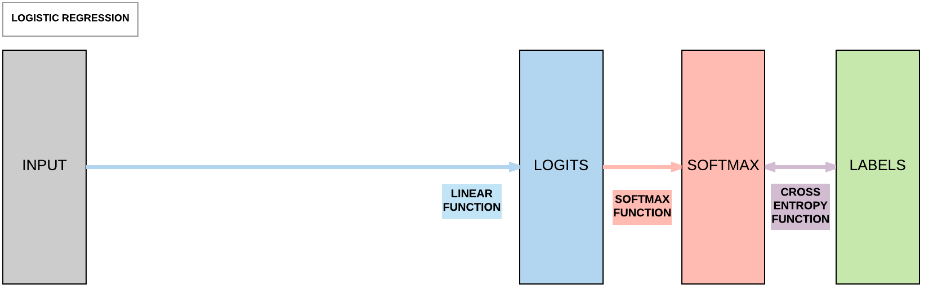



Compared to logistic regression (cannot represent non-linear functions) with only a single linear layer, we know for an FNN we need an additional linear layer and non-linear layer. 
![alt text](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/nn1_params3.png)

For every image, we pass it to our model as :

  first linear layer: Ax+b, input: 784x1 output: 100x1

  second hidden layer of non-linear function: 100x1
  
  third linear layer: input: 100x1 output:10x1 

  This is the final output from our model - 10x1 
 
  Pass this output(basically y = ax+b) to softmax and cross entropy

In [ ]:
class FeedForwardNN(nn.Module):
  def __init__(self,input,hidden,outer): #constructor
    super(FeedForwardNN, self).__init__()      
    self.ff1 = nn.Linear(input,hidden)   #in_features: 784, out_features: 100
    self.ff2 = nn.Sigmoid() 
    self.ff3 = nn.Linear(hidden,outer)  #outer dim: 10

  def forward(self, x): #pass input x image of 784 length(28x28)

    out = self.ff1(x); 
    out = self.ff2(out);
    out = self.ff3(out);
    
    return out;

**Step 4: Instantiate Model Class**

In [ ]:
input = 784
hidden = 100
outer = 10
model = FeedForwardNN(input,hidden,outer)

**Step 5: Instantiate Loss Class**

Unlike linear regression, we do not use MSE here, we need Cross Entry Loss to calculate our loss before we backpropagate and update our parameters.

**criterion = nn.CrossEntropyLoss()**


It does 2 things at the same time.
1. Computes softmax (logistic/softmax function)
2. Computes cross entropy

implies the output from our model will be directly fill int loss class that will compute the probability distribution(softmax) and then the labels( these are computed via cross entropy function)

***This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.***

In [ ]:
criterion = nn.CrossEntropyLoss()  

**Step 6: Instantiate Optimizer Class**

θ = θ − η⋅∇θ

At every iteration, we update our model's parameters

parameters = parameters - learning_rate * parameters_gradients

In [ ]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

In [ ]:
#parameters of model (two linear layers will have A1,B1 and A2,B2)
print(len(list(model.parameters()))) #4
print(list(model.parameters())[0].size()) #size of A in first linear layer
print(list(model.parameters())[1].size()) #size of B in first linear layer

**Step 7: Train Model**

Process 
*  Convert inputs to tensors with gradient accumulation capabilities
*  Clear gradient buffers
*  Get output given inputs
*  Get loss
*  Get gradients w.r.t. parameters
*  Update parameters using gradients
*  parameters = parameters - learning_rate * parameters_gradients
*  REPEAT


In [ ]:
iter = 0
for epoch in range(num_epochs):

  for i, (images , label) in enumerate(train_loader): 
    
    #tuple: tensor [1,28,28] and integer
    #for every iteration of train loader we have images : Size([100, 1, 28, 28]) and labels : Size([100])  
    images = images.view(-1,28*28).requires_grad_() #view(-1, c) : number of columnns = c
    #now images will be [100,786]
    #batch size was 100

    #clear gradients
    optimizer.zero_grad();
    
    #forward pass to model
    out = model(images) # [100,10] , for each image 10 outputs
    
    #for each image out of 100 batch: compute softmax i.e prob distribution over 10 values, calculates the cross entropy funcction()
    #finally calculates cross entropy loss over 100 samples
    loss = criterion(out,label)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    iter += 1
    
    #prediction
    if iter%500 == 0:
      correct = 0
      total = 0
      for images, labels in test_loader:
        images = images.view(-1,28*28).requires_grad_()       
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0) #batch size 100
        correct += (predicted == labels).sum()

      accuracy = 100 * correct / 
      total

            # Print Loss
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))   

**Building NN with GPU**

GPU: 2 things must be on GPU - model - tensors

In [ ]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

##WHILE TRAINING##
images = images.view(-1, 28*28).requires_grad_().to(device)
labels = labels.to(device)

 #######################
 # USE GPU FOR MODEL #
 #######################
 # Total correct predictions
 if torch.cuda.is_available():
   correct += (predicted.cpu() == labels.cpu()).sum()
 else:
   correct += (predicted == labels).sum()
